# Introduction to Neural Networks

In [10]:
import pandas as pd
import numpy as np
import torch
from tdc.single_pred.adme import ADME
from tdc import Evaluator
from tqdm.notebook import tqdm, trange
from torch.utils.data import TensorDataset, DataLoader
from rdkit import Chem
from rdkit.Chem import AllChem
from matplotlib import pyplot as plt
from IPython import display

from typing import List, Tuple


class Featurizer:
    def __init__(self, y_column, smiles_col='Drug', **kwargs):
        self.y_column = y_column
        self.smiles_col = smiles_col
        self.__dict__.update(kwargs)
    
    def __call__(self, df):
        raise NotImplementedError()

#W metodzie tej tworzone są fingerprinty ECFP (Extended-Connectivity Fingerprints)
#z zadanym promieniem i długością za pomocą funkcji GetMorganFingerprintAsBitVect.

class ECFPFeaturizer(Featurizer):
    def __init__(self, y_column, radius=2, length=1024, **kwargs):
        self.radius = radius
        self.length = length
        super().__init__(y_column, **kwargs)
    
    def __call__(self, df):
        fingerprints = []
        labels = []
        for i, row in df.iterrows():
            y = row[self.y_column]
            smiles = row[self.smiles_col]
            mol = Chem.MolFromSmiles(smiles)
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, self.radius, nBits=self.length)
            fingerprints.append(fp)
            labels.append(y)
        fingerprints = np.array(fingerprints)
        labels = np.array(labels)   #zwracana jest tabela z Y i z fingerprintami
        return fingerprints, labels

data = ADME('Solubility_AqSolDB')
split = data.get_split()
rmse = Evaluator(name = 'RMSE')

featurizer = ECFPFeaturizer(y_column='Y')
X_train, y_train = featurizer(split['train'])
X_valid, y_valid = featurizer(split['valid'])
X_test, y_test = featurizer(split['test'])

Found local copy...
Loading...
Done!
[11:04:02] WARNING: not removing hydrogen atom without neighbors
[11:04:02] WARNING: not removing hydrogen atom without neighbors
[11:04:02] WARNING: not removing hydrogen atom without neighbors
[11:04:02] WARNING: not removing hydrogen atom without neighbors
[11:04:02] WARNING: not removing hydrogen atom without neighbors
[11:04:02] WARNING: not removing hydrogen atom without neighbors
[11:04:02] WARNING: not removing hydrogen atom without neighbors
[11:04:02] WARNING: not removing hydrogen atom without neighbors
[11:04:02] WARNING: not removing hydrogen atom without neighbors
[11:04:02] WARNING: not removing hydrogen atom without neighbors
[11:04:02] WARNING: not removing hydrogen atom without neighbors
[11:04:02] WARNING: not removing hydrogen atom without neighbors
[11:04:03] WARNING: not removing hydrogen atom without neighbors
[11:04:03] WARNING: not removing hydrogen atom without neighbors
[11:04:03] WARNING: not removing hydrogen atom withou

In [11]:
def train(X_train, y_train, X_valid, y_valid):
    # Definujemy hiperparametry
    hidden_size = 512 #rozmiar ukrytej warstwy
    epochs = 50 #liczba epok
    batch_size = 64 #rozmiar partii
    learning_rate = 0.0001 #szybkość uczenia się
    
    # model preparation- TO DO
    
    model = torch.nn.Sequential(
        torch.nn.Linear(in_features=1024, out_features=hidden_size), 
        torch.nn.ReLU(),
        torch.nn.Linear(in_features=hidden_size, out_features=hidden_size), 
        torch.nn.ReLU(), #ReLU- funkcja aktywacji
        torch.nn.Linear(in_features=hidden_size, out_features=1)) 
    
    
    # data preparation
    
    #tworzymy tensor, który zawiera dane treningowe i ich etykiety
    dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train.reshape(-1, 1)))
    #dzielimy nasze dane na partie, zmieniamy je 
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    #to samo dla danych walidacyjnych
    valid_dataset = TensorDataset(torch.FloatTensor(X_valid), torch.FloatTensor(y_valid.reshape(-1, 1)))
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    
    
    # prepare metrics plots
    
    #tworzymy wykres live (aktualizuje się na bieżaco w miarę jak trenujemy sieć), 
    #na którym wyświetlane będą wartości metryki podczas trenowania sieci
    
    fig, ax = plt.subplots(ncols=2, figsize=(7, 3), layout="constrained")
    dh = display.display(fig, display_id=True)
    df_metrics = pd.DataFrame()
    
    # training loop
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #Aktualizacji wag sieci neuronowej. Argument model.parameters()- optymalizator będzie aktualizował wagi sieci neuronowej
    loss_fn = torch.nn.MSELoss() #tworzy funkcję straty Mean Squared Error (MSE), która będzie używana do porównywania prognozowanej wartości z rzeczywistą.
    
    for epoch in trange(1, epochs + 1, leave=False): #rozpoczyna pętlę trenowania
        model.train() #ustawiamy model w tryb treningowy
        
        #rozpoczyna pętlę po partii danych treningowych. X to tensor z danymi wejściowymi (przykładami), 
        #a y to tensor z rzeczywistymi wartościami wyjściowymi (etykietami).
        
        for X, y in tqdm(loader, leave=False):
            model.zero_grad() # zeruje pochodne funkcji straty po wagach przed rozpoczęciem obliczeń w kolejnej pętli.
            preds = model(X) #wykonuje prognozy na podstawie danych wejściowych X z wykorzystaniem wytrenowanego modelu.
            loss = loss_fn(preds, y) #oblicza funkcję straty między prognozami
            loss.backward() #oblicza gradienty (pochodne) funkcji straty po wagach
            optimizer.step() #optymalizator Adam aktualizuje wagi modelu zgodnie z obliczonymi gradientami.
        
        
        # validation loop
        model.eval() #ustawia model w tryb ewaluacji (testowania)
        preds_batches = []
        
        #rozpoczyna pętlę po partii danych walidacyjnych. X to tensor z danymi wejściowymi (przykładami), 
        #a y to tensor z rzeczywistymi wartościami wyjściowymi (etykietami).
        
        with torch.no_grad():
            for X, y in tqdm(valid_loader, leave=False):
                preds = model(X)
                preds_batches.append(preds.cpu().detach().numpy())
        preds = np.concatenate(preds_batches) #wykonuje prognozy na podstawie danych wejściowych X z wykorzystaniem wytrenowanego modelu.
        rmse_score = rmse(y_valid, preds)
        
        
        #DataFrame, do którego dodawane są metryki treningowe i walidacyjne (epoka, wartość funkcji straty i wartość RMSE
        df_metrics = df_metrics.append({'epoch': epoch, 'loss': loss.item(), 'rmse': rmse_score}, ignore_index=True)
        #dwa subwykresy, na których wyświetlane są odpowiednio wartości funkcji straty i RMSE
        ax[0].clear() #wyczyszczenia subwykresu przed narysowaniem nowych wartości
        
        #rysuje wykres z wartościami df_metrics.epoch na osi X i df_metrics.loss lub df_metrics.rmse na osi Y
        ax[0].plot(df_metrics.epoch, df_metrics.loss)
        ax[0].set_title('training loss')
        ax[0].set_xlabel('epoch')
        ax[0].set_ylabel('MSE')
        ax[1].clear()
        ax[1].plot(df_metrics.epoch, df_metrics.rmse)
        ax[1].set_title('validation RMSE')
        ax[1].set_xlabel('epoch')
        ax[1].set_ylabel('RMSE')
        dh.update(fig) #funkcja odpowiedzialna za wyświetlenie zmodyfikowanego wykresu tutaj 
    plt.close()
    return model


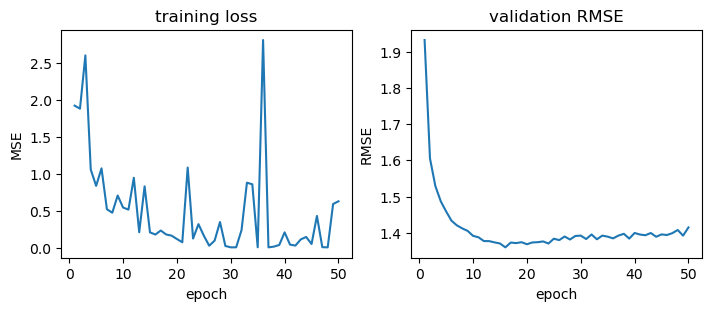

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

RMSE = 1.360
Looks OK!


In [12]:
def predict(model, X_test, y_test):
    # hyperparameters definition
    # (but this doesn't change the training results, it's only to optimize the eval speed)
    batch_size = 64

    # data preparation
    dataset = TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test.reshape(-1, 1)))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    # evaluation loop
    preds_batches = []
    with torch.no_grad():
        for X, y in tqdm(loader):
            preds = model(X)
            preds_batches.append(preds.cpu().detach().numpy())
    preds = np.concatenate(preds_batches)
    return preds

# training
model = train(X_train, y_train, X_valid, y_valid)

# evaluation
predictions = predict(model, X_test, y_test)

rmse_score = rmse(y_test, predictions)
print(f'RMSE = {rmse_score:.3f}')
assert rmse_score < 1.6, "It should be possible to obtain RMSE lower than 1.6"
print('Looks OK!')

In [2]:
import pandas as pd
import numpy as np
import torch
from tdc.single_pred.adme import ADME
from tdc import Evaluator
from tqdm.notebook import tqdm, trange
from torch.utils.data import TensorDataset, DataLoader
from rdkit import Chem
from rdkit.Chem import AllChem
from matplotlib import pyplot as plt
from IPython import display

from typing import List, Tuple

## Molecular grafs

In [20]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader


def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise ValueError("input {0} not in allowable set{1}:".format(
            x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))


def one_of_k_encoding_unk(x, allowable_set):
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))


class GraphFeaturizer(Featurizer):
    def __call__(self, df):
        graphs = []
        labels = []
        for i, row in df.iterrows():
            y = row[self.y_column]
            smiles = row[self.smiles_col]
            mol = Chem.MolFromSmiles(smiles)
            
            edges = []
            for bond in mol.GetBonds():
                start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
                edges.append([start, end])
                edges.append([end, start]) # assume the graph is undirected
            edges = np.array(edges)
            
            nodes = []
            for atom in mol.GetAtoms():
                results = one_of_k_encoding_unk(atom.GetSymbol(), ['C', 'N', 'O', 'S', 'F', 'P', 'Cl', 'Br', 'I', 'unknown'])
                results += one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5, 6])
                results += one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 'unknown'])
                results += [atom.GetIsAromatic()]
                nodes.append(results)     
            nodes = np.array(nodes)
            
            graphs.append((nodes, edges.T))
            labels.append(y)
        labels = np.array(labels)
        return [Data(
            x=torch.FloatTensor(x), 
            edge_index=torch.LongTensor(edge_index), 
            y=torch.FloatTensor([y])
        ) for ((x, edge_index), y) in zip(graphs, labels)]

In [21]:
featurizer = GraphFeaturizer('Y')
graph = featurizer(split['test'].iloc[:1])[0]

assert graph.x.ndim == 2, 'The atom features should be a matrix with dimensions (number of atoms) x (number of features)'
assert graph.edge_index.ndim == 2, 'The edges should be represented as a matrix of atom pairs'
assert graph.edge_index.shape[0] == 2, 'The first dimension should be 2 (we need atom pairs)'
assert isinstance(graph.y, torch.FloatTensor) and graph.y.shape == (1,), 'The graph label should be assigned to the variable `y`'
print('Looks OK!')

Looks OK!


## Graph neural networks

In [27]:
from torch_geometric.loader import DataLoader as GraphDataLoader


# prepare data loaders
batch_size = 64
train_loader = GraphDataLoader(featurizer(split['train']), batch_size=batch_size, shuffle=True)
valid_loader = GraphDataLoader(featurizer(split['valid']), batch_size=batch_size)
test_loader = GraphDataLoader(featurizer(split['test']), batch_size=batch_size)

[11:44:58] WARNING: not removing hydrogen atom without neighbors
[11:44:58] WARNING: not removing hydrogen atom without neighbors
[11:44:58] WARNING: not removing hydrogen atom without neighbors
[11:44:58] WARNING: not removing hydrogen atom without neighbors
[11:44:58] WARNING: not removing hydrogen atom without neighbors
[11:44:58] WARNING: not removing hydrogen atom without neighbors
[11:44:59] WARNING: not removing hydrogen atom without neighbors
[11:44:59] WARNING: not removing hydrogen atom without neighbors
[11:44:59] WARNING: not removing hydrogen atom without neighbors
[11:44:59] WARNING: not removing hydrogen atom without neighbors
[11:44:59] WARNING: not removing hydrogen atom without neighbors
[11:44:59] WARNING: not removing hydrogen atom without neighbors
[11:44:59] WARNING: not removing hydrogen atom without neighbors
[11:44:59] WARNING: not removing hydrogen atom without neighbors
[11:44:59] WARNING: not removing hydrogen atom without neighbors
[11:44:59] WARNING: not r

In [34]:
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn.functional as F


class GraphNeuralNetwork(torch.nn.Module):  # TODO: assign hyperparameters to attributes and define the forward pass
    def __init__(self, hidden_size):
        super().__init__()
        self.conv1 = GCNConv(in_channels=75, out_channels=hidden_size)
        self.conv2 = GCNConv(in_channels=hidden_size, out_channels=hidden_size)
        self.fc = torch.nn.Linear(hidden_size, 1)
    
    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return x

In [35]:
def train(train_loader, valid_loader):
    # hyperparameters definition
    hidden_size = 512
    epochs = 10
    learning_rate = 0.0001
    
    # model preparation
    model = GraphNeuralNetwork(hidden_size)  # TODO: you can add more hyperparameters if needed
    model.train()
    
    # training loop
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = torch.nn.MSELoss()
    
    for epoch in trange(1, epochs + 1, leave=False):
        for data in tqdm(train_loader, leave=False):
            x, edge_index, batch, y = data.x, data.edge_index, data.batch, data.y
            model.zero_grad()
            preds = model(x, edge_index, batch)
            loss = loss_fn(preds, y.reshape(-1, 1))
            loss.backward()
            optimizer.step()
    return model


def predict(model, test_loader):
    # evaluation loop
    preds_batches = []
    with torch.no_grad():
        for data in tqdm(test_loader):
            x, edge_index, batch = data.x, data.edge_index, data.batch
            
            preds = model(x, edge_index, batch)
            preds_batches.append(preds.cpu().detach().numpy())
    preds = np.concatenate(preds_batches)
    return preds


# training
model = train(train_loader, valid_loader)

# evaluation
predictions = predict(model, test_loader)

rmse_score = rmse(y_test, predictions.flatten())

print(f'RMSE = {rmse_score:.2f}')
assert rmse_score < 1.4, "It should be possible to obtain RMSE lower than 1.4"
print('Looks OK!')

TypeError: GraphNeuralNetwork.__init__() missing 2 required positional arguments: 'hidden_dim' and 'num_classes'